In [33]:
# Tensorflow imports
from tensorflow.test import is_gpu_available
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [34]:
sns.set(rc={'figure.figsize':(18, 4)})

In [2]:
is_gpu_available()

True

### Connect to mongo database

In [3]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.external

In [4]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop('_id', 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df['price_diff'] = df['price'].diff()
df = df.dropna()

df.head()

,n_tweets,price,sentiment,price_diff
timestamp,,,,
2017-08-02 06:00:00,892.0,2732.12,0.076942,-3.15
2017-08-02 07:00:00,830.0,2731.96,0.080092,-0.16
2017-08-02 08:00:00,819.0,2710.21,0.082844,-21.75
2017-08-02 09:00:00,1196.0,2719.31,0.087544,9.10
2017-08-02 10:00:00,1315.0,2732.99,0.061601,13.68


### Function to create timeline plot

In [5]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")
    
    fig, ax1 = plt.subplots()

    ax1.plot(df['2019-01-02 08:00:00':][first_feature], label=first_feature)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df['2019-01-02 08:00:00':][second_feature], color='orange', label=second_feature)
    ax2.legend(loc='upper right')

E:\Users\Jules\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


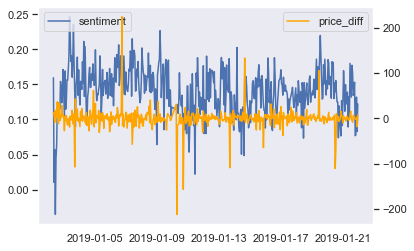

In [6]:
plot_timeline('sentiment', 'price_diff')

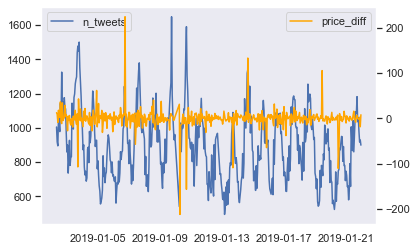

In [7]:
plot_timeline('n_tweets', 'price_diff')

### Prepare training data

In [8]:
n_steps = 12
n_features = 3
train_size = int(.75 * len(df))

In [9]:
def split_sequence(sequence, n_steps, y_col=0):
    X = []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        
    return np.array(X)

#### Train test split

In [10]:
prices = df['price'].values
prices_train, prices_test = prices[:train_size], prices[train_size:]

In [11]:
sentiment = df['sentiment'].values
sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]

In [12]:
n_tweets = df['n_tweets'].values
n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]

In [13]:
train = np.stack([prices_train, sentiment_train, n_tweets_train], axis=1)
test = np.stack([prices_test, sentiment_test, n_tweets_test], axis=1)

#### Scale the data

In [14]:
scaler = StandardScaler()

In [15]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#### Generate sequences

In [16]:
X_train = split_sequence(train_scaled, n_steps)

In [17]:
X_test = split_sequence(test_scaled, n_steps)

In [18]:
y_prices = df['price']

y_train = y_prices.iloc[n_steps:len(X_train)+n_steps].values
y_test = y_prices.iloc[-len(X_test):].values

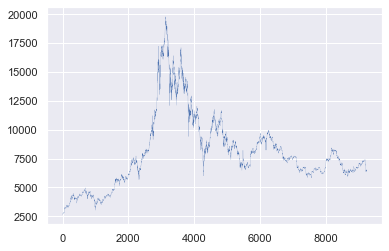

In [19]:
sns.set(style='darkgrid')
plt.plot(y_train, linewidth=.15);

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9240, 12, 3), (9240,), (3073, 12, 3), (3073,))

In [21]:
y_train

array([2705.97, 2710.11, 2705.64, ..., 6444.22, 6457.58, 6431.09])

In [22]:
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])

### Build the keras model

In [23]:
# model.add(BatchNormalization())
# model.add(Dropout(.65))
# model.add(Dense(41, activation='relu'))
# model.add(LSTM(32, activation='relu'))
# model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))

In [24]:
first_dense = 54
n_dense = 2
other_dense = 57

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_model():
    model = Sequential()
    model.add(Dense(first_dense, activation='relu', input_shape=(n_steps*n_features,), 
                    kernel_regularizer=regularizers.l2(0.01)))
    
    for _ in range(n_dense):
        model.add(Dense(other_dense, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=root_mean_squared_error)
    
    return model

In [25]:
# Create the model
model = build_model()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=16)

# Checkpoints
checkpointer = ModelCheckpoint(filepath='models/keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

# Fit the model
model.fit(
    X_train, 
    y_train, 
    validation_split=0.33,
    epochs=512, 
    batch_size=64,
    callbacks=[checkpointer, early_stopping]);

Train on 6196 samples, validate on 3053 samples
Epoch 1/512
5504/6196 [=========================>....] - ETA: 0s - loss: 9112.6174
Epoch 00001: val_loss improved from inf to 7200.14240, saving model to models/keras_weights.hdf5
6196/6196 [==============================] - 1s 175us/sample - loss: 9126.8826 - val_loss: 7200.1424
Epoch 2/512
5376/6196 [=========================>....] - ETA: 0s - loss: 7650.7199
Epoch 00002: val_loss improved from 7200.14240 to 5636.78896, saving model to models/keras_weights.hdf5
6196/6196 [==============================] - 0s 67us/sample - loss: 7297.4719 - val_loss: 5636.7890
Epoch 3/512
5248/6196 [========================>.....] - ETA: 0s - loss: 4117.5006
Epoch 00003: val_loss improved from 5636.78896 to 3669.85681, saving model to models/keras_weights.hdf5
6196/6196 [==============================] - 0s 71us/sample - loss: 4023.0813 - val_loss: 3669.8568
Epoch 4/512
5568/6196 [=========================>....] - ETA: 0s - loss: 3036.4652
Epoch 00004: v

5440/6196 [=========================>....] - ETA: 0s - loss: 155.2870
Epoch 00032: val_loss improved from 68.08744 to 67.74874, saving model to models/keras_weights.hdf5
6196/6196 [==============================] - 0s 66us/sample - loss: 154.5066 - val_loss: 67.7487
Epoch 33/512
6016/6196 [============================>.] - ETA: 0s - loss: 155.5756
Epoch 00033: val_loss did not improve from 67.74874
6196/6196 [==============================] - 0s 64us/sample - loss: 155.4411 - val_loss: 84.0501
Epoch 34/512
5184/6196 [========================>.....] - ETA: 0s - loss: 153.5486
Epoch 00034: val_loss did not improve from 67.74874
6196/6196 [==============================] - 0s 62us/sample - loss: 154.9183 - val_loss: 68.1693
Epoch 35/512
5952/6196 [===========================>..] - ETA: 0s - loss: 152.2211
Epoch 00035: val_loss did not improve from 67.74874
6196/6196 [==============================] - 0s 63us/sample - loss: 152.1087 - val_loss: 80.2777
Epoch 36/512
6016/6196 [=============

5184/6196 [========================>.....] - ETA: 0s - loss: 149.5520
Epoch 00066: val_loss did not improve from 60.42390
6196/6196 [==============================] - 0s 62us/sample - loss: 148.5841 - val_loss: 84.0125
Epoch 67/512
5952/6196 [===========================>..] - ETA: 0s - loss: 151.7048
Epoch 00067: val_loss did not improve from 60.42390
6196/6196 [==============================] - 0s 66us/sample - loss: 151.7020 - val_loss: 108.7237
Epoch 68/512
5440/6196 [=========================>....] - ETA: 0s - loss: 147.0363
Epoch 00068: val_loss did not improve from 60.42390
6196/6196 [==============================] - 0s 60us/sample - loss: 147.6230 - val_loss: 64.2138
Epoch 69/512
6080/6196 [============================>.] - ETA: 0s - loss: 153.7055
Epoch 00069: val_loss did not improve from 60.42390
6196/6196 [==============================] - 0s 63us/sample - loss: 153.2004 - val_loss: 74.4161
Epoch 70/512
5504/6196 [=========================>....] - ETA: 0s - loss: 151.0848
E

5248/6196 [========================>.....] - ETA: 0s - loss: 149.8302
Epoch 00100: val_loss did not improve from 58.43172
6196/6196 [==============================] - 0s 60us/sample - loss: 150.3192 - val_loss: 76.5028
Epoch 101/512
5760/6196 [==========================>...] - ETA: 0s - loss: 149.1268
Epoch 00101: val_loss did not improve from 58.43172
6196/6196 [==============================] - 0s 58us/sample - loss: 148.8396 - val_loss: 71.9110
Epoch 102/512
5440/6196 [=========================>....] - ETA: 0s - loss: 148.0219
Epoch 00102: val_loss did not improve from 58.43172
6196/6196 [==============================] - 0s 59us/sample - loss: 147.8758 - val_loss: 84.3668
Epoch 103/512
5120/6196 [=======================>......] - ETA: 0s - loss: 149.8074
Epoch 00103: val_loss did not improve from 58.43172
6196/6196 [==============================] - 0s 61us/sample - loss: 150.5909 - val_loss: 69.5735
Epoch 104/512
5376/6196 [=========================>....] - ETA: 0s - loss: 147.913

### Load model

In [26]:
def load_trained_model():
    model = build_model()
    model.load_weights('models/keras_weights.hdf5')
    
    return model

model = load_trained_model()

#### Baseline functions
* Roll - always predict previous price
* Zero - always predict zero

In [31]:
def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 1)[1:], data[1:]))

def predict_zero(data):
    return sqrt(mean_squared_error(np.zeros_like(data), data))

In [84]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [85]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $34.91
Test baseline zero: $5324.13
Test RMSE: $42.84


In [87]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $116.52
Train baseline zero: $8603.73
Train RMSE: $103.52


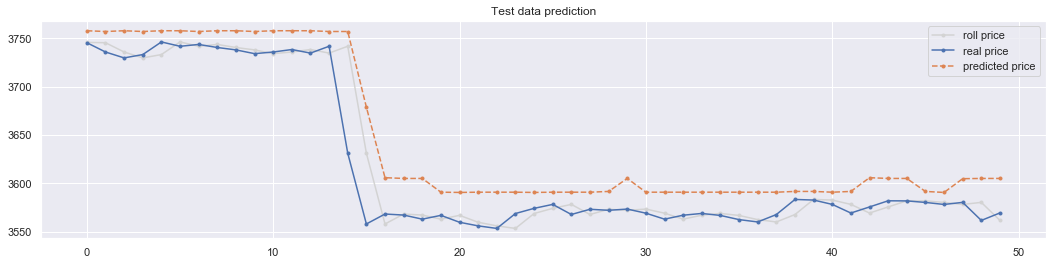

In [88]:
plt.plot(np.roll(y_test, 1)[-50:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-50:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-50:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

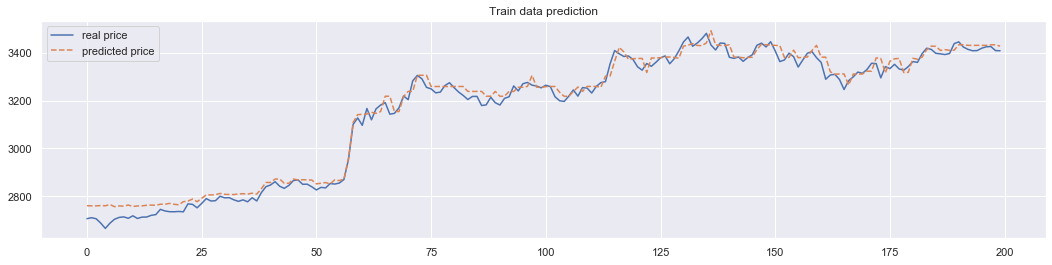

In [89]:
plt.plot(y_train[:200], label='real price')
plt.plot(y_hat_train[:200], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();

### XGBoost

In [25]:
from xgboost import XGBRegressor

In [62]:
xgboost = XGBRegressor(gpu_id=0,
                 tree_method='gpu_hist',
                 n_estimators=1000) 

In [63]:
xgboost.fit(X_train, y_train, verbose=10)

[14:39:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [64]:
# Predict using the test data
y_hat = xgboost.predict(X_test)
y_hat_train = xgboost.predict(X_train)

In [65]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $34.91
Test baseline zero: $5324.13
Test RMSE: $43.99


In [66]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $116.52
Train baseline zero: $8603.73
Train RMSE: $64.87


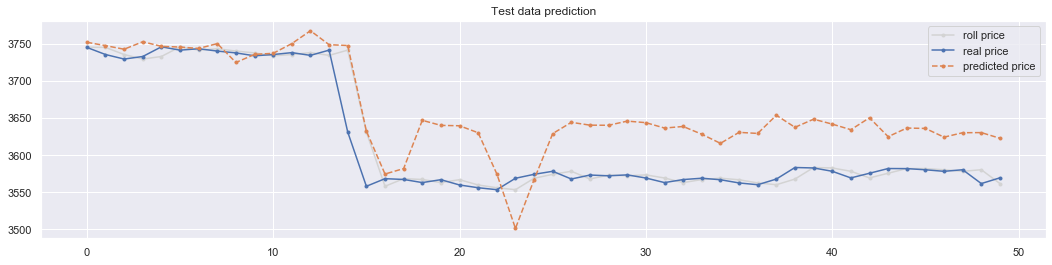

In [67]:
plt.plot(np.roll(y_test, 1)[-50:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-50:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-50:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

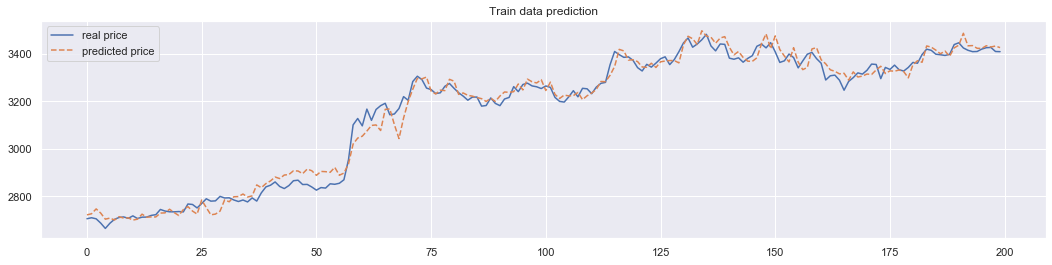

In [68]:
plt.plot(y_train[:200], label='real price')
plt.plot(y_hat_train[:200], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();